### The Global Fund Transaction Summary  
This notebook includes an exploratory data analysis of the TGF's transaction data.  
  
The key objective is to map order and scheduled/actual delivery times to identify countries where orders are consistently delayed, potentially impacting diagnostic availability and public health outcomes. 

In [1]:
# importing packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry

sns.set(style="whitegrid")

In [6]:
# importing tgf transaction summary dataset - filtered for 'TB molecular diagnostics'
tgf_trans = pd.read_csv('TGF/TGF_Transactions.csv', encoding='utf-16', sep='\t')
# dropping first row
tgf_trans = tgf_trans.drop(index=0)

In [7]:
tgf_trans

,Country/Teritorry,Grant Name,Supplier/Agent/Manufacturer/Intermediatry,Manufacturer,Product Category,Product,Description,Product Pack,Purchase Order Date,Scheduled Delivery Date,...,Some or All of Goods Prepaid,Freight Cost,Supplier Invoice Number,Purchase Order Number,Invoice Currency Name,Primary Key,Status,Pack quantity,Product pack (USD),Total Product Cost (USD)
1,Afghanistan,AFG-T-UNDP,Direct from Mfg,Cepheid,"Diagnostic, PPE and Medical Device",TB molecular diagnostics,Cepheid GeneXpert Model GX-IV- 4 module Instru...,1 unit / test,29-Jul-15,15-Oct-15,...,No,Reported separately,9210000633,AFG10-GP404135-1,United States Dollar,61987,Admin-Publish,4,"17,500.00","70,000"
2,Afghanistan,AFG-T-UNDP,Direct from Mfg,Cepheid,"Diagnostic, PPE and Medical Device",TB molecular diagnostics,Cepheid GeneXpert Model GX-IV- 4 module Instru...,1 unit / test,05-Oct-17,19-Dec-17,...,No,Reported separately,9210003398,AFG10-GP406031-1,United States Dollar,73391,Admin-Publish,11,"17,500.00","192,500"
3,Afghanistan,AFG-T-UNDP,Direct from Mfg,Cepheid,"Diagnostic, PPE and Medical Device",TB molecular diagnostics,"Cepheid Xpert MTB/RIF kit (10s, 50s) [CGXMTBRIF]",50 tests,29-Jul-15,15-Oct-15,...,No,Reported separately,9210000633,AFG10-GP404135-1,United States Dollar,61988,Admin-Publish,24,499.00,"11,976"
4,Afghanistan,AFG-T-UNDP,Direct from Mfg,Cepheid,"Diagnostic, PPE and Medical Device",TB molecular diagnostics,"Cepheid Xpert MTB/RIF kit (10s, 50s) [CGXMTBRIF]",50 tests,29-Jul-15,01-Mar-16,...,No,Reported separately,9210001694,GP404135-1,United States Dollar,66556,Admin-Publish,95,499.00,"47,405"
5,Afghanistan,AFG-T-UNDP,Direct from Mfg,Cepheid,"Diagnostic, PPE and Medical Device",TB molecular diagnostics,"Cepheid Xpert MTB/RIF kit (10s, 50s) [CGXMTBRIF]",50 tests,05-Oct-17,19-Dec-17,...,No,Reported separately,9210003398,AFG10-GP406031-1,United States Dollar,73392,Published,110,499.00,"54,890"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2118,Zimbabwe,ZWE-T-MOHCC,"PPM, through IDA",Cepheid,"Diagnostic, PPE and Medical Device",TB molecular diagnostics,"Cepheid Xpert MTB/RIF kit (10s, 50s) [CGXMTBRIF]",50 tests,05-Jun-17,27-Nov-17,...,Yes,Reported separately,PQ16102268,SQ16102268,United States Dollar,75722,Published,"2,600",499.00,"1,297,400"
2119,Zimbabwe,ZWE-T-MOHCC,"PPM, through IDA",Cepheid,"Diagnostic, PPE and Medical Device",TB molecular diagnostics,"Cepheid Xpert MTB/RIF kit (10s, 50s) [CGXMTBRIF]",50 tests,12-Jun-17,03-Jul-17,...,Yes,Reported separately,ZWE-T-MOHCCSQ16102268,17100080 SO,United States Dollar,74006,Published,950,499.00,"474,050"
2120,Zimbabwe,ZWE-T-MOHCC,"PPM, through IDA",Cepheid,"Diagnostic, PPE and Medical Device",TB molecular diagnostics,"Cepheid Xpert MTB/RIF kit (10s, 50s) [CGXMTBRIF]",50 tests,18-Aug-17,16-Oct-17,...,Yes,Reported separately,ZWE-T-MOHCCSQ16102268,17101570 SO,United States Dollar,74004,Published,"1,200",499.00,"598,800"
2121,Zimbabwe,ZWE-T-MOHCC,"PPM, through IDA",Cepheid,"Diagnostic, PPE and Medical Device",TB molecular diagnostics,"Cepheid Xpert MTB/RIF kit (10s, 50s) [CGXMTBRIF]",50 tests,31-Oct-17,13-Dec-17,...,Yes,Reported separately,SQ16102268,16102268SQ,United States Dollar,74003,Published,450,499.00,"224,550"


In [8]:
tgf_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2122 entries, 1 to 2122
Data columns (total 22 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   Country/Teritorry                            2122 non-null   object
 1   Grant Name                                   2122 non-null   object
 2   Supplier/Agent/Manufacturer/Intermediatry    2122 non-null   object
 3   Manufacturer                                 2122 non-null   object
 4   Product Category                             2122 non-null   object
 5   Product                                      2122 non-null   object
 6   Description                                  2122 non-null   object
 7   Product Pack                                 2122 non-null   object
 8   Purchase Order Date                          2122 non-null   object
 9   Scheduled Delivery Date                      2122 non-null   object
 10  Actual Deliv

#### 1. Cleaning

In [9]:
# transforming date columns into datetime format
date_columns = ['Purchase Order Date', 'Scheduled Delivery Date', 'Actual Delivery Date']

for col in date_columns:
    # issue with date columns - 'sept' to 'sep'
    tgf_trans[col] = tgf_trans[col].str.replace('Sept', 'Sep')
    tgf_trans[col] = pd.to_datetime(tgf_trans[col], format='%d-%b-%y')

In [10]:
# transforming columns to numerical
cols_to_num = ['Pack quantity', 'Product pack (USD)', 'Total Product Cost (USD)']

for col in cols_to_num:
    tgf_trans[col] = tgf_trans[col].str.replace(',', '').astype(float)
    tgf_trans[col] = pd.to_numeric(tgf_trans[col], errors='coerce')

In [11]:
# renaming columns
tgf_trans = tgf_trans.rename(columns={"Supplier/Agent/Manufacturer/Intermediatry  ": "Supplier/Agent/Manufacturer/Intermediatry",
                                      "Manufacturer  ": "Manufacturer", 
                                      "Description ": "Description",
                                      "Freight Cost ": "Freight Cost"})

In [12]:
# excluding regional/multicountry observations - e.g. 'Africa', 'Americas', etc.
valid_codes = [country.alpha_3 for country in pycountry.countries]
tgf_trans['Country Code'] = tgf_trans['Grant Name'].str[:3]
tgf_trans = tgf_trans[tgf_trans['Country Code'].isin(valid_codes)]

In [13]:
tgf_trans.groupby('Manufacturer')['Description'].value_counts()

Manufacturer           Description                                                                               
Cepheid                Cepheid Xpert MTB/RIF kit (10s, 50s) [CGXMTBRIF]                                              460
                       Cepheid Xpert MTB/RIF Ultra (50s) [GXMTB/RIF-ULTRA-50]                                        338
                       Cepheid GeneXpert Model GX-IV- 4 module Instrument with laptop [GXIV-4-L]                     100
                       Cepheid GeneXpert Model GX-IV- 4 module Instrument with desktop [GXIV-4D]                      86
                       Cepheid Xpert MTB/XDR kit (10s) [GXMTB/XDR-10]                                                 82
                       Cepheid GeneXpert Model GX-XVI-16 module instrument with desktop[GXXVI-16-D]                   19
                       Cepheid GeneXpert Model GX-IV R2 2-module (10-color) Instrument with laptop [GXIV-2-L-10C]     13
                       Cepheid GeneXper

In [14]:
# keep only Cepheid products
tgf_ceph = tgf_trans[(tgf_trans['Manufacturer']=='Cepheid') & tgf_trans['Description'].str.startswith('Cepheid Xpert')]

In [24]:
tgf_ceph 
# summarize pack quantity per year for Afghanistan
afg_summary = tgf_ceph[tgf_ceph['Country/Teritorry'] == 'Afghanistan'].groupby(tgf_ceph['Actual Delivery Date'].dt.year)['Pack quantity'].sum()
print("\nAfghanistan Pack Quantity by Year:")
print(afg_summary)



Afghanistan Pack Quantity by Year:
Actual Delivery Date
2015      24.0
2016      95.0
2017     110.0
2019     200.0
2020    1100.0
2021    1536.0
Name: Pack quantity, dtype: float64


In [15]:
# creating columns for expected delivery time and delivery delays (in number of days)
tgf_ceph['Delivery Time'] = (tgf_ceph['Actual Delivery Date'] - tgf_ceph['Purchase Order Date']).dt.days
tgf_ceph['Delivery Delay'] = (tgf_ceph['Actual Delivery Date'] - tgf_ceph['Scheduled Delivery Date']).dt.days

/var/folders/w9/4s00gf1j7sl8k190_53qgb7c0000gn/T/ipykernel_67836/3149299256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tgf_ceph['Delivery Time'] = (tgf_ceph['Actual Delivery Date'] - tgf_ceph['Purchase Order Date']).dt.days
/var/folders/w9/4s00gf1j7sl8k190_53qgb7c0000gn/T/ipykernel_67836/3149299256.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tgf_ceph['Delivery Delay'] = (tgf_ceph['Actual Delivery Date'] - tgf_ceph['Scheduled Delivery Date']).dt.days


#### 2. Analysis

In [16]:
# number of orders placed
pd.DataFrame(tgf_ceph['Country/Teritorry'].value_counts().sort_values(ascending=False))

,count
Country/Teritorry,
Ukraine,49
Myanmar,45
Viet Nam,36
Somalia,32
Cambodia,28
...,...
Palestine,1
Dominican Republic,1
Côte d'Ivoire,1


In [17]:
# total amount spent
pd.DataFrame(tgf_ceph.groupby('Country/Teritorry')['Total Product Cost (USD)'].sum().sort_values(ascending=False))

,Total Product Cost (USD)
Country/Teritorry,
India,34869230.0
Viet Nam,19023914.0
Philippines,17395343.0
Nigeria,16495942.0
Bangladesh,16125786.0
...,...
Dominican Republic,4990.0
Chad,4491.0
Korea (Democratic Peoples Republic),2994.0


In [18]:
# average delivery time
pd.DataFrame(tgf_ceph.groupby('Country/Teritorry')['Delivery Time'].mean().sort_values(ascending=False))

,Delivery Time
Country/Teritorry,
Congo (Democratic Republic),542.250000
Viet Nam,411.027778
Comoros,333.000000
Bangladesh,311.166667
Mongolia,308.846154
...,...
Egypt,43.000000
Djibouti,39.400000
Mali,21.000000


In [19]:
# median delivery delay
pd.DataFrame(tgf_ceph.groupby('Country/Teritorry')['Delivery Delay'].median().sort_values(ascending=False))

,Delivery Delay
Country/Teritorry,
Korea (Democratic Peoples Republic),125.0
Cuba,108.0
Sri Lanka,71.0
Congo (Democratic Republic),62.5
Syrian Arab Republic,58.0
...,...
Azerbaijan,-25.5
Niger,-25.5
Dominican Republic,-33.0


In [20]:
# descriptive statistics on delivery delays
tgf_ceph['Delivery Delay'].describe()

count    886.000000
mean      10.156885
std       82.994583
min     -477.000000
25%       -6.000000
50%        0.000000
75%       21.000000
max      573.000000
Name: Delivery Delay, dtype: float64

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


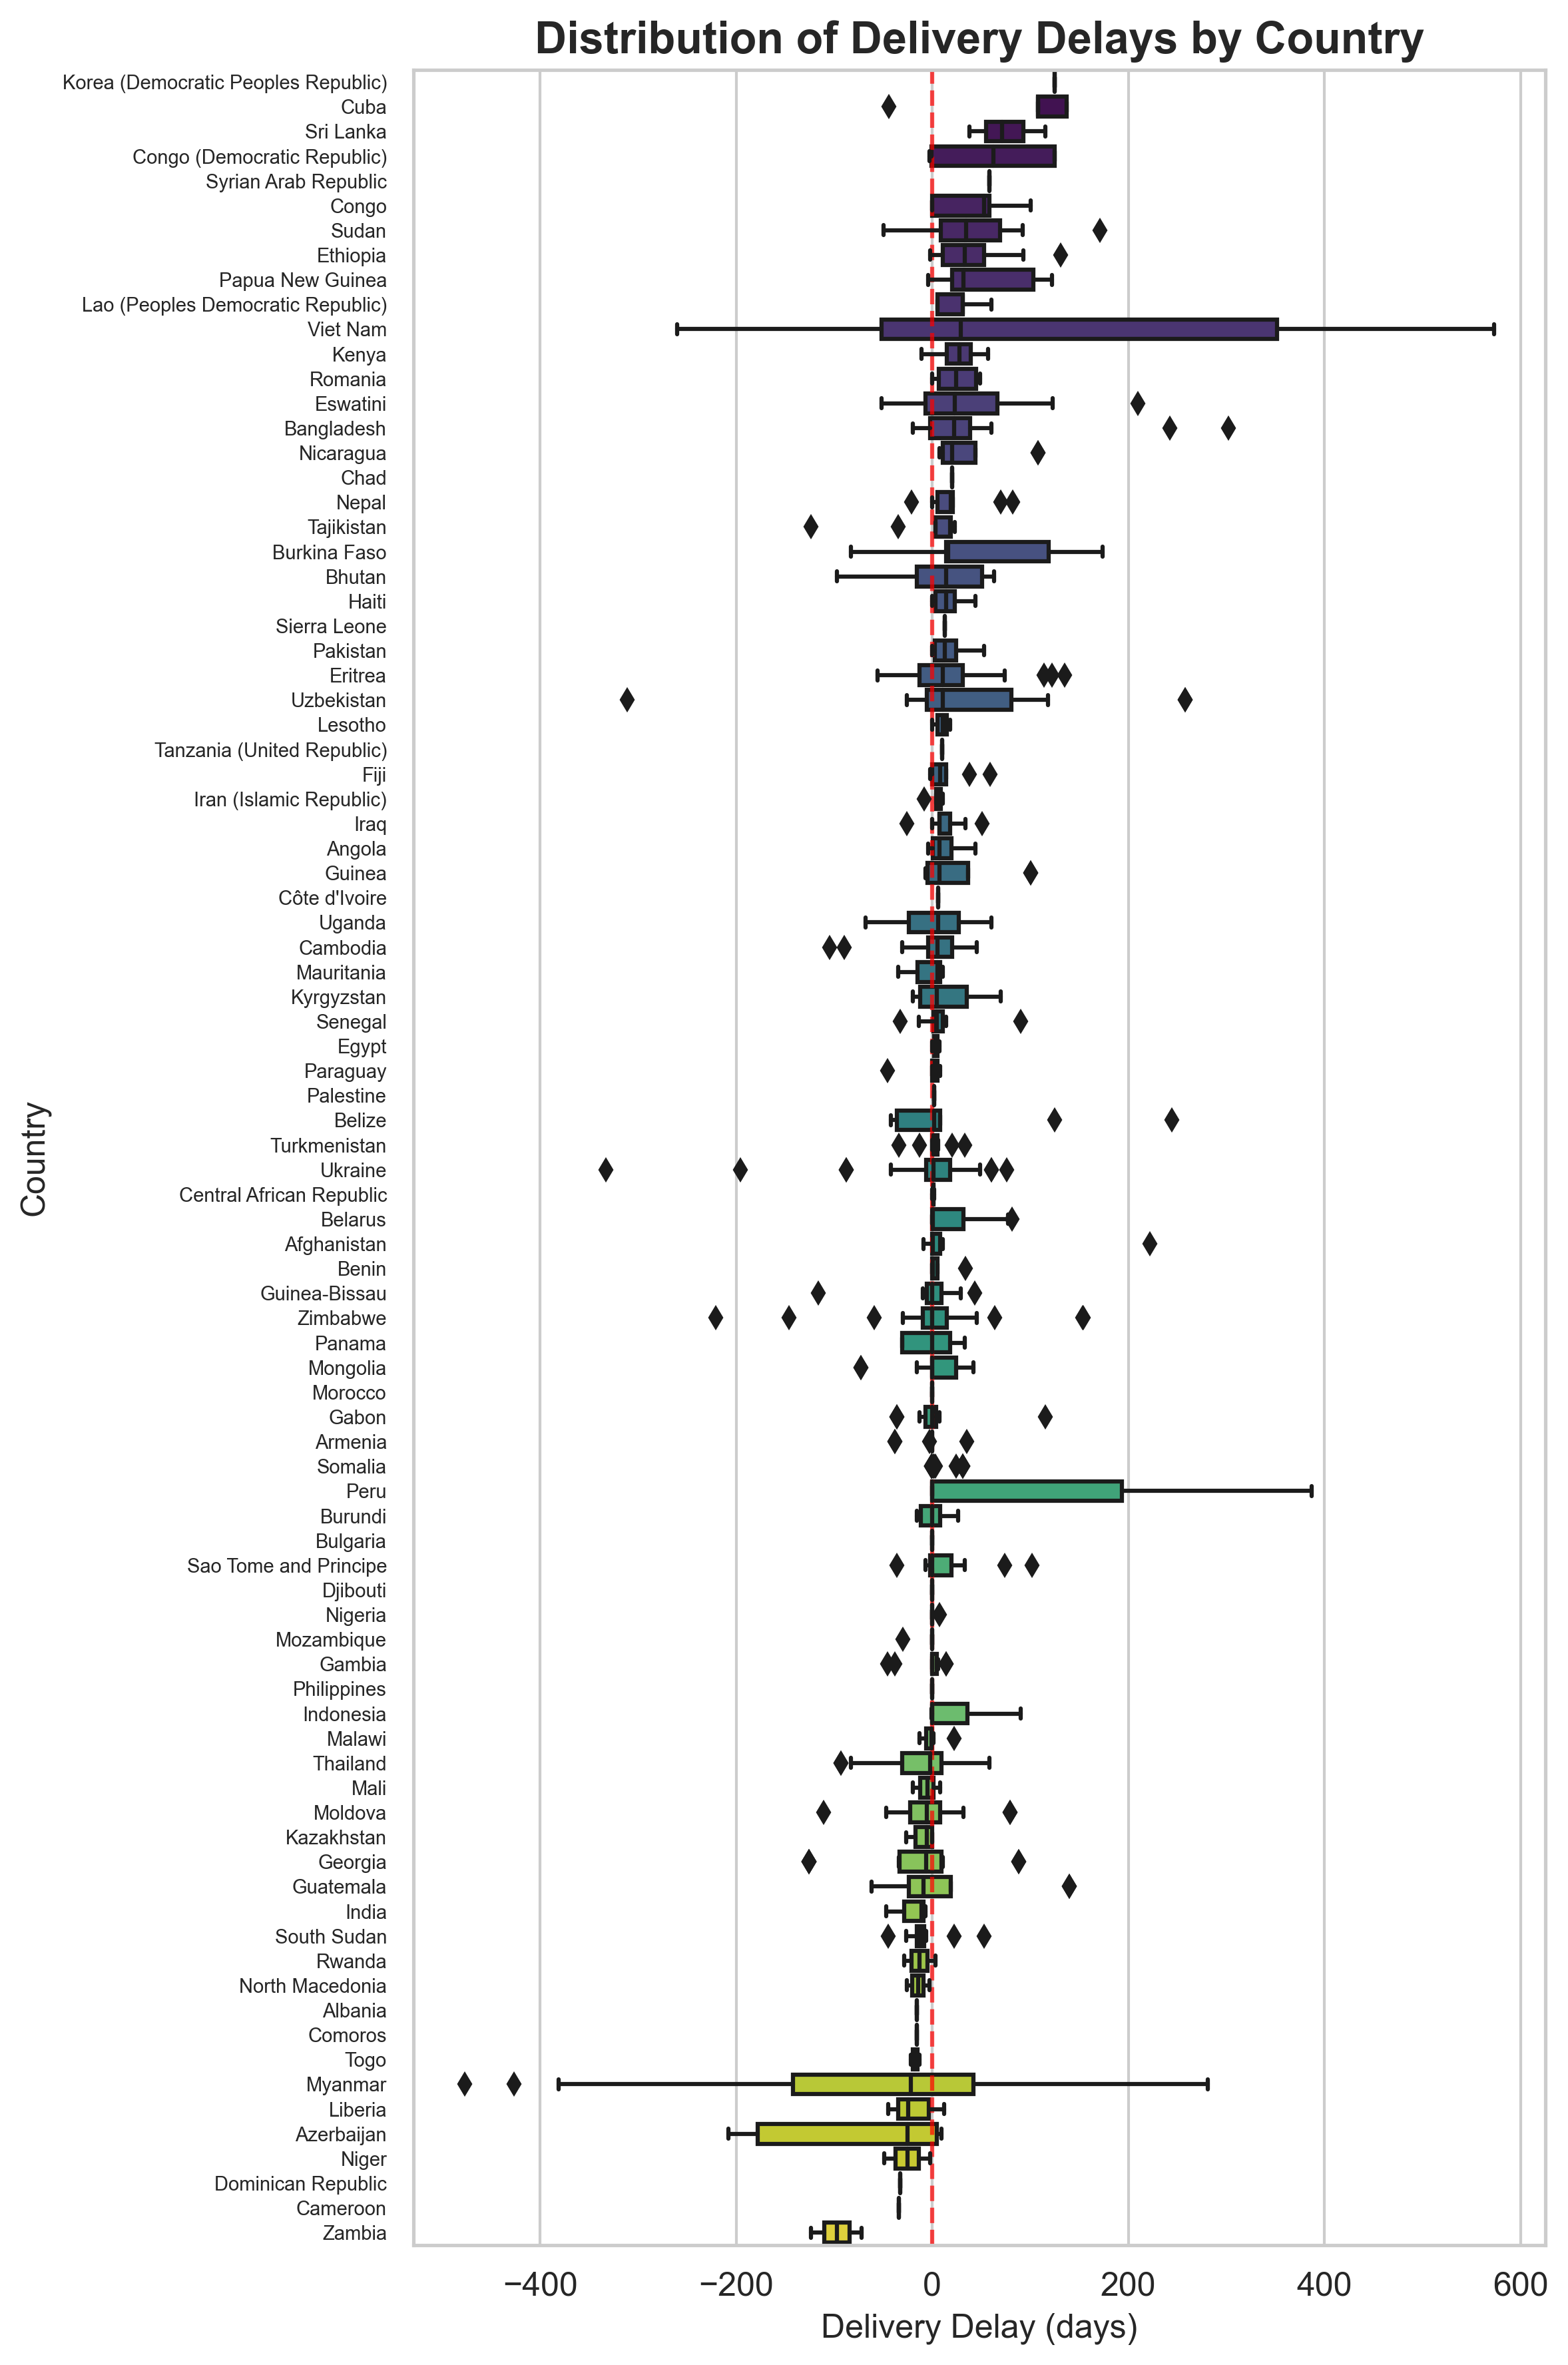

In [21]:
tgf_ceph_grouped = pd.DataFrame(
    tgf_ceph.groupby('Country/Teritorry')['Delivery Delay'].median().sort_values(ascending=False)).reset_index()

plt.figure(figsize=(8, 12), dpi=300)
plt.axvline(x=0, color='red', alpha=0.7, ls='--')

sns.boxplot(
    data=tgf_ceph, 
    x='Delivery Delay', 
    y='Country/Teritorry',
    # sort by mean delay
    order=tgf_ceph_grouped['Country/Teritorry'],
    palette='viridis')

plt.title('Distribution of Delivery Delays by Country', fontsize=16, weight='bold')
plt.xlabel('Delivery Delay (days)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=7)

plt.tight_layout()
plt.show()

In [22]:
from IPython.display import Image
Image("/Users/henriquerodrigues/Desktop/LSE/Y2/Capstone/Plots/median-delivery-delay-for-tb-molecular-diagnostics.png")

FileNotFoundError: No such file or directory: '/Users/henriquerodrigues/Desktop/LSE/Y2/Capstone/Plots/median-delivery-delay-for-tb-molecular-diagnostics.png'

FileNotFoundError: No such file or directory: '/Users/henriquerodrigues/Desktop/LSE/Y2/Capstone/Plots/median-delivery-delay-for-tb-molecular-diagnostics.png'

<IPython.core.display.Image object>